# Advanced Lane Lines Finding

In [1]:
import os
import sys

import numpy as np
import cv2
import glob
from sklearn import linear_model
from moviepy.editor import VideoFileClip
from collections import deque

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 1. Remove distortion

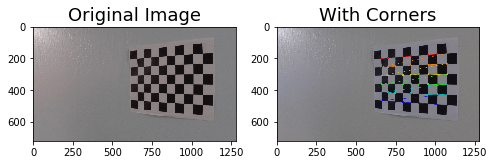

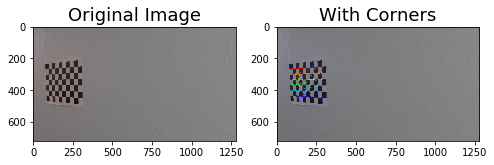

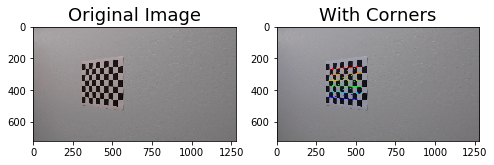

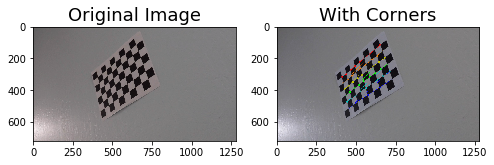

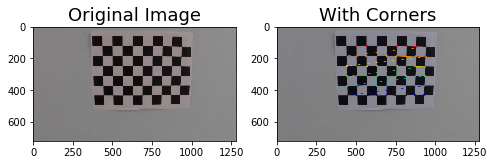

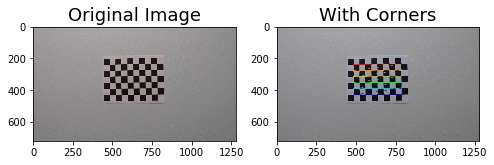

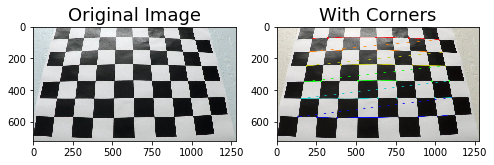

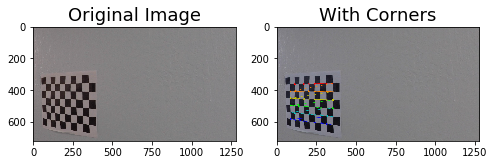

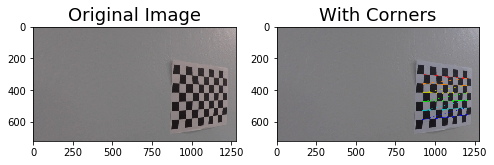

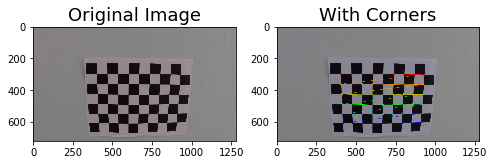

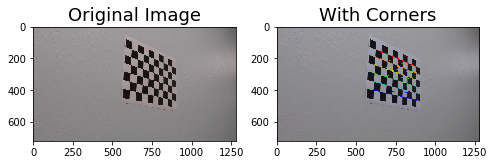

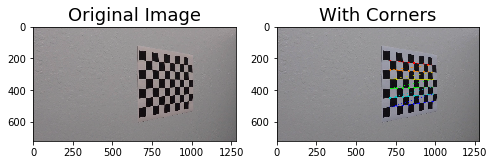

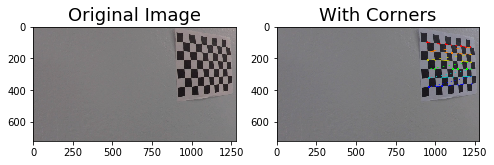

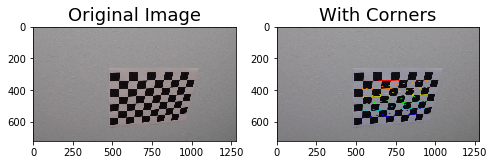

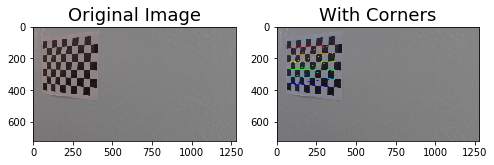

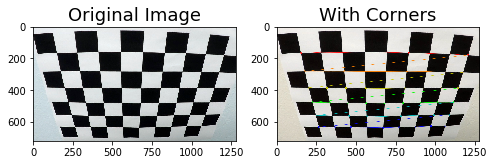

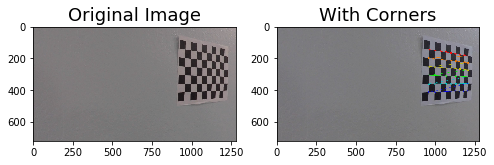

In [3]:
# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

objp =  np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] #3d points in the real world
imgpoints = [] #2d points in the image plane

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    
    # Make a list of calibration imageson images
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None) #Only if it finds the corners


    # If found, draw corners and add object points and image points.
    if ret == True:
        # Draw and display the corners
        imgpoints.append(corners)
        objpoints.append(objp)
        
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=18)
        


Next with a function called *undistortion()* I will calculate the camera calibration matrix and distortion coefficients.

In [4]:
def undistortion(image, show=True, read=True):
    if read:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=20)
    else:
        return dst

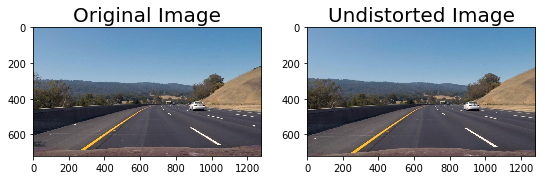

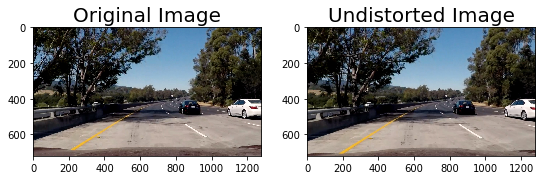

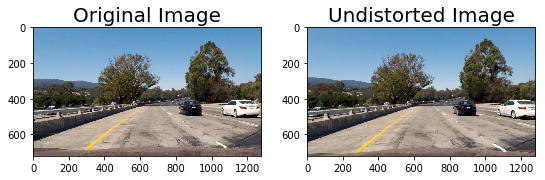

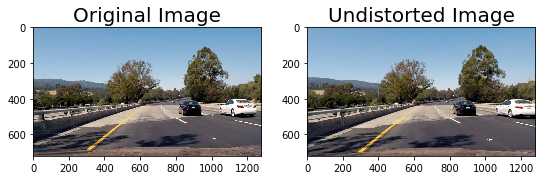

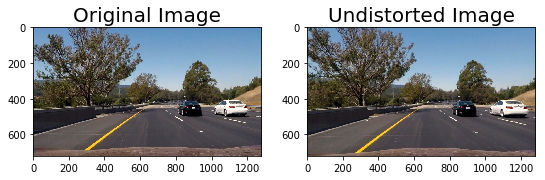

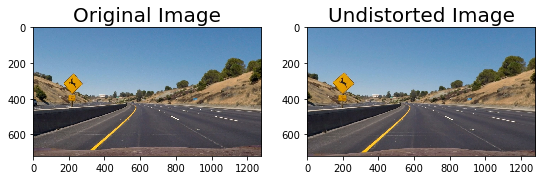

In [5]:
images = glob.glob('test_images/test*.jpg')
for image in images:
    undistortion(image)

## 2. Perspective Transform

I first undistort the images and now it is usefull to transform the image to a bird's eye view. It displays the lines in a way that they are parallel to eachother. 

In [6]:
def birds_eye(img, display=True, read=True):
    if read:
        undist = undistortion(img, show = False)
    else:
        undist = undistortion(img, show = False, read = False)
    img_size = (undist.shape[1], undist.shape[0])
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                     [1250, 720],[40,720]])
    dst = np.float32([[0, 0], [1280, 0],
                     [1250, 720], [40, 720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    else:
        return warped, M

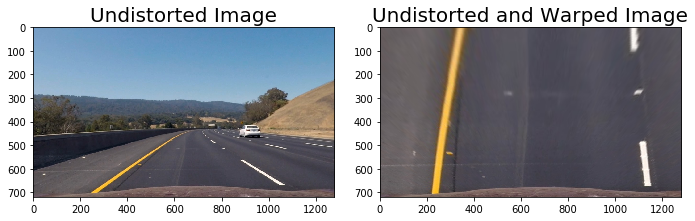

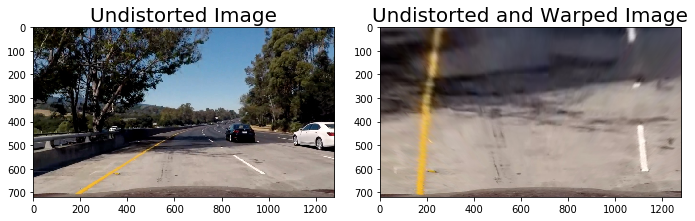

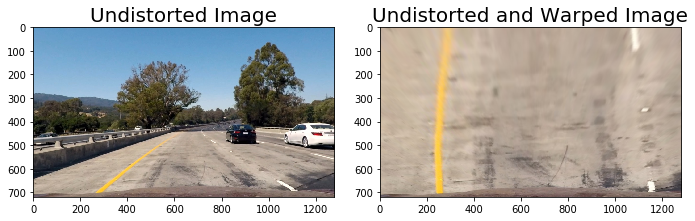

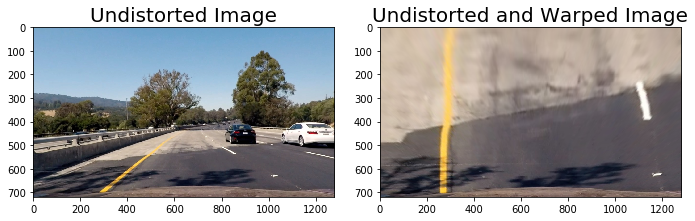

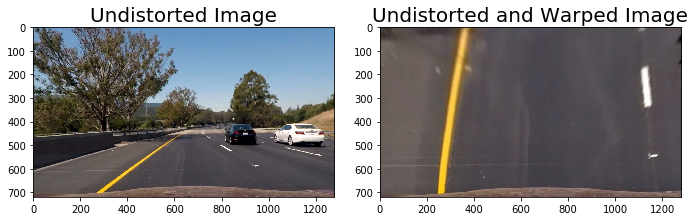

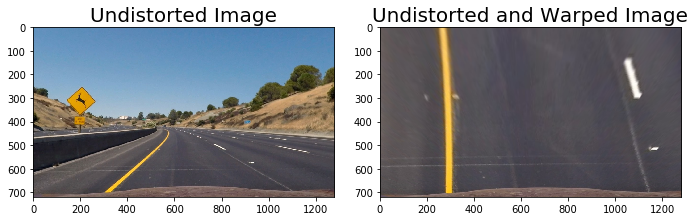

In [7]:
for image in glob.glob('test_images/test*.jpg'):
    birds_eye(image)

## 3. Binary Threshods

It is time to apply both, color and gradient thresholding. 

In [13]:
#It gets initialized just once
#I do not apply any sobel so far

def thresholds(image, show=True):

    warped, M = birds_eye(image, display=False)
    img= warped
    
    s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]
    
    #Threshold color channel
    s_thresh_min = 180 #It was 170 during the Udacity training
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel) #Transform the channel into zeros
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
       
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    
    if show == True:
        # Plotting thresholded images
        f, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
        
        ax1.set_title('Original Image', fontsize=16)
        ax1.imshow(cv2.cvtColor(undistortion(image, show=False),cv2.COLOR_BGR2RGB))
        
        ax2.set_title('Warped Image', fontsize=16)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        
        ax3.set_title('s binary threshold', fontsize=16)
        ax3.imshow(s_binary, cmap='gray')
        
        ax4.set_title('b binary threshold', fontsize=16)
        ax4.imshow(b_binary, cmap='gray')
        
        ax5.set_title('l binary threshold', fontsize=16)
        ax5.imshow(l_binary, cmap='gray')

        ax6.set_title('Combined color thresholds', fontsize=16)
        ax6.imshow(combined_binary, cmap='gray')
        
        
    else: 
        return combined_binary
        

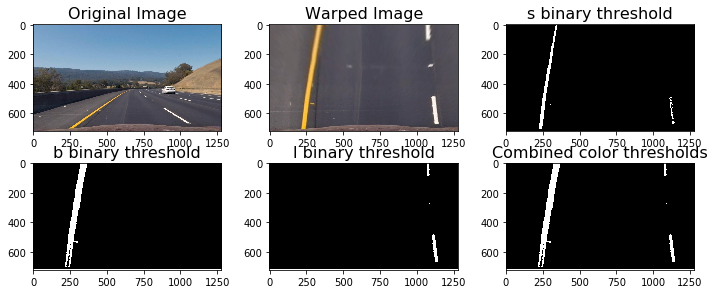

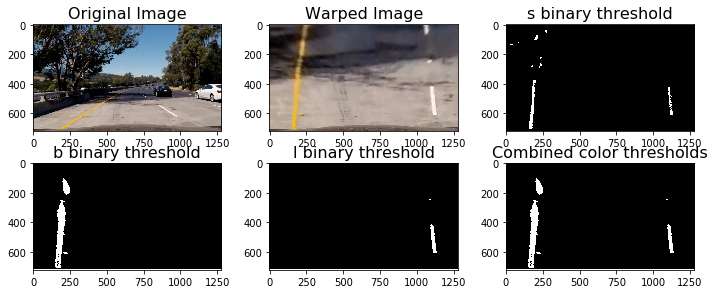

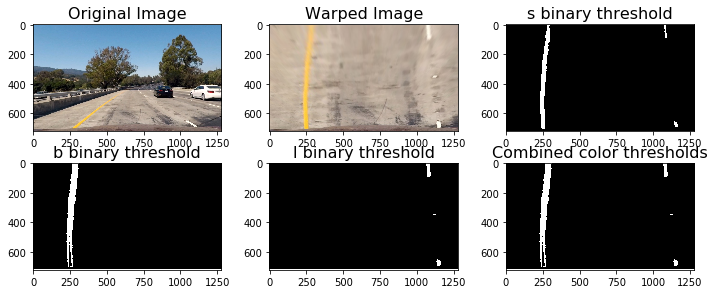

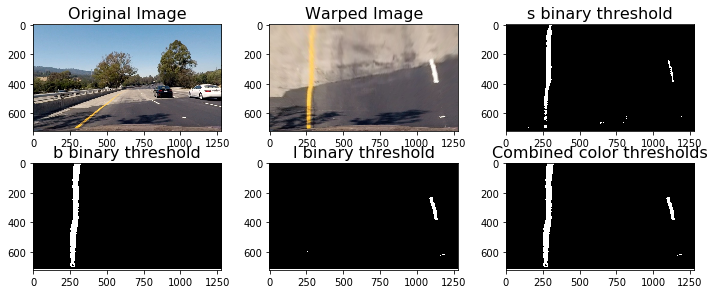

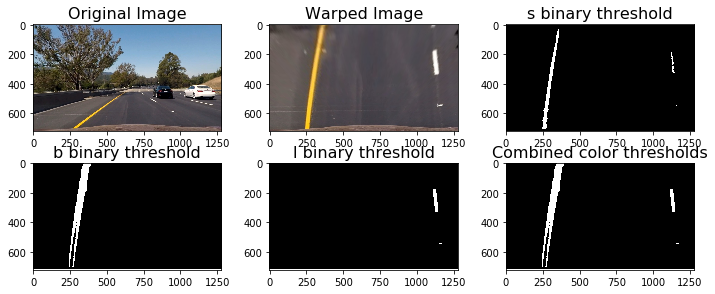

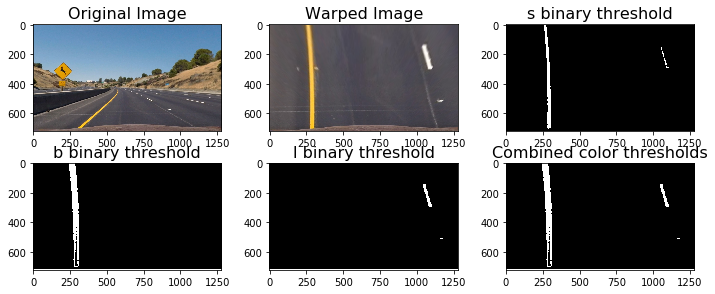

In [14]:
for image in glob.glob('test_images/test*.jpg'):
    thresholds(image)

## 4. Fitting a polynomial to the lane lines.

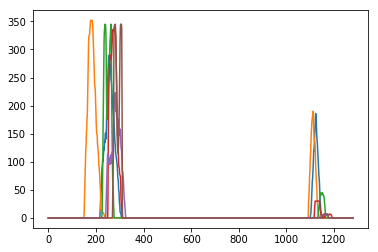

In [16]:
def fill_lane(image):
    
    combined_binary = thresholds(image, show=False)
    image = combined_binary
    rightx = []
    righty = []
    
    #It grabs only the bottom half of the image
    bottom_half = image[image.shape[0]//2:,:]
    
    #Then sum across image pixels vertically 
    histogram = np.sum(bottom_half, axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    plt.plot(histogram)

for image in glob.glob('test_images/test*.jpg'):
    fill_lane(image)
    


    
    
    